In [2]:
import sys
sys.path.append('/kaggle/working')

In [5]:
import cv2
from PIL import Image
import numpy as np

In [4]:
class img_proc:
    def adaptive_intensity_scaling(
        self,
        image : np.ndarray[np.uint8], 
        epsilon = 0.0001,
        quantiles : tuple[int,int] = (0.25,0.95),
        rescale = False,
        ret_thresholds = False,
    ) -> np.ndarray[np.uint8]:
        """
        Adaptively rescales the brightness of the image by performing min max scaling between the 
        -quantiles[0]% quantile value (value which is greater than quantiles[0]% of all values present)
        and
        -quantiles[1]% quantile value (value which is greater than quantiles[1]% of all values present)
        epsilon is a small constant added to prevent zero division error when min max scaling
        """
        image_reciprocated = image.astype(np.float64)
        min_val,max_val = np.quantile(image_reciprocated.flatten(),quantiles)
        image_reciprocated[image_reciprocated < min_val] = min_val
        image_reciprocated[image_reciprocated > max_val] = max_val
        if rescale:
            image_reciprocated = (image_reciprocated - image_reciprocated.min()) / (image_reciprocated.max() - image_reciprocated.min() + epsilon)
            image_reciprocated = (image_reciprocated * 255)
            
        if ret_thresholds:
            return image_reciprocated.astype(np.uint8), min_val,max_val
        return image_reciprocated.astype(np.uint8)
    
    
    def resize_image_with_aspect_ratio(self,image, max_size=1200):
        h, w = image.shape[:2]

        # Determine the scale factor and new dimensions
        if h > w:
            scale_factor = max_size / h
            new_h = max_size
            new_w = int(w * scale_factor)
        else:
            scale_factor = max_size / w
            new_w = max_size
            new_h = int(h * scale_factor)
        # Resize the image
        resized_image = cv2.resize(image, (new_w, new_h))
        return resized_image
    
    def get_segmentation_mask_temp(self,img_slice,max_size = 1000, threshold = True, threshold_and_smooth = True):
        img_slice = cv2.cvtColor(img_slice, cv2.COLOR_RGB2GRAY)
        img_slice = self.resize_image_with_aspect_ratio(img_slice, max_size = max_size)
        # img_slice, min_val,max_val = self.adaptive_intensity_scaling(img_slice,quantiles=[0.25,0.75], rescale = True, ret_thresholds = True)
        img_slice = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(50, 50)).apply(img_slice)
        # bias_adaption = adaptive_intensity_scaling(clahe_adapted,quantiles=[0.10,0.90], rescale = True)
        # clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50)).apply(bias_adaption)
        img_slice, min_val,max_val= self.adaptive_intensity_scaling(img_slice,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
        mask = img_slice
        if threshold or threshold_and_smooth:
            mask = ((mask < 90))*np.uint8(255)
        return mask


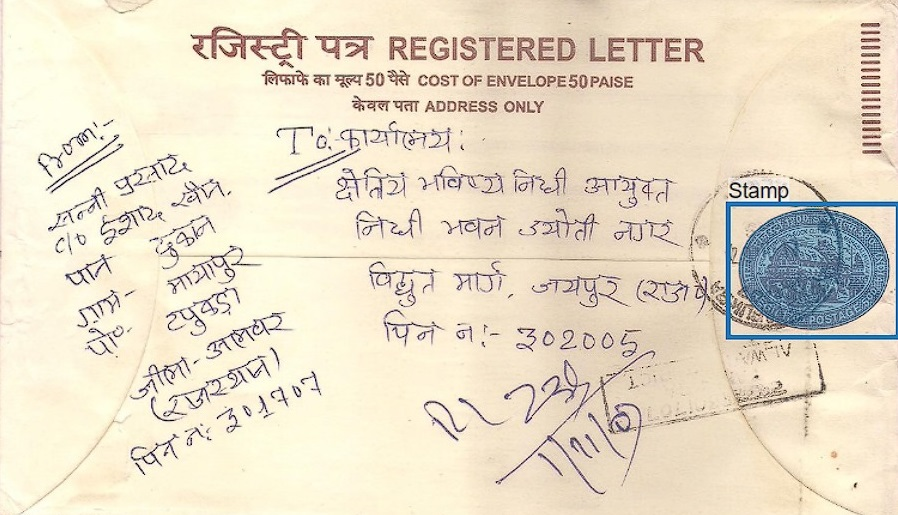

In [6]:
img = Image.open('data/post_image.jpeg')
img

In [7]:
img_arr = np.array(img)
print(img_arr.shape)

(515, 898, 3)


In [8]:
processed_img = img_proc().get_segmentation_mask_temp(img_arr,700)

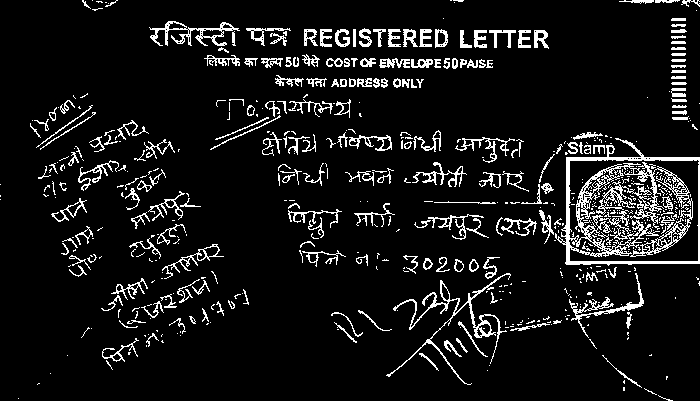

In [9]:
Image.fromarray(processed_img)

In [3]:
import os
import requests
def download_from_bse_india(url, file_output_dir = './', file_name = 'document.pdf', chunk_size = 1024 * 1024 * 2):
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,/;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-encoding": "gzip, deflate, br, zstd",
        "accept-language": "en-US,en;q=0.9",
        "cache-control": "no-cache, no-store, must-revalidate",
        "pragma": "no-cache",
        "expires": "0",
        "priority": "u=0, i",
        "referer": "https://www.google.com/",
        "sec-ch-ua": '"Chromium";v="128", "Not;A=Brand";v="24", "Google Chrome";v="128"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Windows"',
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "cross-site",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"
    }
    response = requests.get(url,headers = headers, stream=True)
    os.makedirs(file_output_dir, exist_ok=True)
    if response.ok:
        print(f"status code : {response.status_code} file_size : {int(response.headers.get('Content-Length')) / 1024 / 1024 : .2f}MB")
        output_path = os.path.join(file_output_dir, file_name)
        with open(output_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    file.write(chunk)
        print(f"PDF downloaded successfully to {output_path}")
    else:
        print(f"Failed to download PDF. Status code: {response.status_code}")

In [5]:
download_from_bse_india('https://www.bseindia.com/xml-data/corpfiling/AttachLive/d608e774-dbbb-47c8-80aa-74c96ccd39a2.pdf','something','asdf.pdf')

status code : 200 file_size :  11.52MB
PDF downloaded successfully to something/asdf.pdf
